# Lab 3 - Neural and neurosymbolic search

## Imports 

In [18]:
import re
import itertools
import math
import time
import random
from collections import Counter
from pprint import pprint

In [19]:
import numpy as np
import pandas as pd
from numpy.random import choice, randint
from IPython.display import HTML, display, clear_output
import matplotlib.pyplot as plt
import ipywidgets as widgets

In [20]:
# Utilities for plotting
from utilities import \
    progress, compute_global_limits_mh, compute_global_limits_smc, plot_mh_trace_upto, plot_state_2d

In [362]:
# Utilities for enumeration
from utilities import enumerate_full_sentences, enumerate_trees, enumerate_full_sentences_bottomup, \
    enumerate_trees_bottomup, compute_likelihood_bs, compute_likelihood_lt

In [22]:
# Various utils for manipulating trees
from utilities import \
    generate_tree, tree_to_sentence, get_nonterminal_nodes, set_subtree, mutate_tree, \
    compute_tree_probability, compute_likelihood, compute_unnormalized_posterior

In [23]:
# MHMC sampler
from utilities import propose_tree, get_coordinates, mh_sampler

In [249]:
from utilities import smc_sampler

In [24]:
# NOTE: PatchFastRL needs to run **before** the imports below
from unsloth import FastLanguageModel, is_bfloat16_supported, PatchFastRL
PatchFastRL("GRPO", FastLanguageModel)

In [25]:
import torch, gc
from datasets import load_dataset, Dataset
from transformers import EarlyStoppingCallback, TextStreamer, TrainingArguments
from trl import SFTTrainer, GRPOConfig, GRPOTrainer
from unsloth.chat_templates import get_chat_template
from vllm import SamplingParams

In [26]:
from dotenv import load_dotenv, find_dotenv
import os
from openai import OpenAI

In [27]:
from utilities import extract_xml_answer, extract_xml_reasoning, produce_tasks, get_data

## Our DSLs again

String transformation DSL, with a grammar and interpretation function:

In [ ]:
bsgrammar = {
    # A binary string can be a 0, a 1, or some transformation of string(s).
    "S": [
        (["0"], 0.2),
        (["1"], 0.2),
        # concatenate
        (["C", "(", "S", ",", "S", ")"], 0.2),
        # duplicate
        (["D", "(", "S", ")"], 0.1),
        # triplicate
        (["T", "(", "S", ")"], 0.1),
        # reverse
        (["R", "(", "S", ")"], 0.1),
        # negate
        (["N", "(", "S", ")"], 0.1)
    ]
}

BS_NONTERMINALS  = list(bsgrammar.keys())
BS_TERMINALS = []
for l in bsgrammar.values():
    for j in l:
        for k in j[0]:
            if k not in BS_NONTERMINALS:
                BS_TERMINALS.append(k)

BS_TERMINALS = list(set(BS_TERMINALS))

bs_eval_dict = {
    "C": lambda x, y: str(x) + str(y),
    "D": lambda s: str(s) * 2,
    "T": lambda s: str(s) * 3,
    "R": lambda s: str(s)[::-1],
    "N": lambda s: str(s).translate({48: 49, 49: 48}),
    # Bit-wiseduplication: duplicate each bit in the string individually.
    "B": lambda s: "".join(c * 2 for c in str(s)),
    # Swap halves: for odd-length strings, leave the middle bit in place.
    "S": lambda s: (str(s)[(len(str(s)) // 2) + 1:] + str(s)[len(str(s)) // 2] + str(s)[:len(str(s)) // 2])
         if len(str(s)) % 2 == 1 else (str(s)[len(str(s)) // 2:] + str(s)[:len(str(s)) // 2]),
    # Rotate by one: rotate the string to the left by one position.
    "O": lambda s: str(s)[1:] + str(s)[0] if len(str(s)) > 0 else str(s),
    # Interleaving: merge two strings character by character; the remainder of the longer string is appended.
    "I": lambda x, y: "".join(a + b for a, b in zip(str(x), str(y))) +
         (str(x)[len(str(y)):] if len(str(x)) > len(str(y)) else str(y)[len(str(x)):]),
}

Same for our binary string grammar:

In [ ]:
ltgrammar = {
    "T": [
        (["LISTF"], 0.5),
        (["compose", "(", "LISTF", ",", "LISTF", ")"], 0.5)
    ],
    # Atomic transformations
    "LISTF": [
        (["reverse"],                  0.2),
        (["sort"],                     0.2),
        (["map_", "(", "INTF", ")"],   0.2),
        (["filter_", "(", "COND", ")"],0.2),
        (["truncate", "(", "INT", ")"],0.2)
    ],
    # Operators for map: simple arithmetic operations on x.
    "INTF": [
        (["plus", "(", "INT", ")"],    0.25),
        (["minus", "(", "INT", ")"],   0.25),
        (["times", "(", "INT", ")"],   0.25),
    ],
    # Conditions for filter: e.g., keeping even or odd numbers.
    "COND": [
        (["even"], 0.5),
        (["gt", "(", "INT", ")"],  0.3),
        (["not_", "(", "COND", ")"], 0.1),
        (["and_", "(", "COND", ",", "COND", ")"], 0.1),
        (["or_", "(", "COND", ",", "COND", ")"], 0.1)
    ],
    "INT": [
        ([str(i)], 1/5) for i in range(1,6)
    ]
}

LT_NONTERMINALS  = list(ltgrammar.keys())
LT_TERMINALS = []
for l in ltgrammar.values():
    for j in l:
        for k in j[0]:
            if k not in LT_NONTERMINALS:
                LT_TERMINALS.append(k)

LT_TERMINALS = list(set(LT_TERMINALS))

lt_eval_dict = {
    # Composes two list transformation functions.
    "compose":  lambda f, g: lambda L: g(f(L)),
    # Basic list transformations.
    "reverse":  lambda L: list(reversed(L)),
    "sort":     lambda L: sorted(L),
    "truncate": lambda i: lambda L: L[:i],
    # Higher-order functions that expect a function and return a list transformation.
    "map_":     lambda f: lambda L: [f(x) for x in L],
    "filter_":  lambda f: lambda L: [x for x in L if f(x)],
    # Integer transformation functions used inside map.
    "plus":     lambda n: lambda x: x + n,
    "minus":    lambda n: lambda x: x - n,
    "times":    lambda n: lambda x: x * n,
    # Predicates for filtering.
    "even":     lambda x: x % 2 == 0,
    "gt":       lambda i: lambda x: x>i,
    "and_":     lambda f, g: lambda x: f(x) and g(x),
    "or_":      lambda f, g: lambda x: f(x) or g(x),
    "not_":     lambda f: lambda x: not f(x),
}

## Neural program synthesis I - binary strings domain

Note: I am running this on my personal laptop, which has an RTX3050 8GBs (I know, I know, it's an old laptop). Looking at Unsloth [requirements](https://docs.unsloth.ai/get-started/beginner-start-here/unsloth-requirements), I can fine-tune LLMs with 11B using QLoRA (4-bit) VRAM.

We are using the following libraries:
- Huggingface's Transformers 
- Unsloth: integrates with TRL and Transformers, can fine-tune LLMs using a variety of methods much faster than other libraries.
- vllm: Starts a server to do LLM stuff with, makes inference faster.
- trl: Reinforcement Learning fine-tuning

In [17]:
max_seq_length = 1024 # Can increase for longer reasoning traces
lora_rank = 64 # Larger rank = smarter, but slower

In [61]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))

True
1
0
NVIDIA GeForce RTX 3050 Ti Laptop GPU


##  Neural program synthesis II - not-so-simple list transformation 

### Get base model

In [18]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "Qwen/Qwen2.5-0.5B-Instruct",
    max_seq_length = max_seq_length,
    load_in_4bit = True, # False for LoRA 16bit
    fast_inference = True, # Enable vLLM fast inference
    max_lora_rank = lora_rank,
    gpu_memory_utilization = 0.5, # Reduce if out of memory
)

model = FastLanguageModel.get_peft_model(
    model,
    # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    r=lora_rank, 
    # Which parts of the model are we gonna train?
    target_modules = [
        "q_proj", 
        "k_proj", 
        "v_proj", 
        "o_proj",
        "gate_proj", 
        "up_proj", 
        "down_proj",
    ], 
    lora_alpha = lora_rank,
    # Enable long context finetuning
    use_gradient_checkpointing = "unsloth", 
    random_state = 3407,
)

==((====))==  Unsloth 2025.2.12: Fast Qwen2 patching. Transformers: 4.49.0.
   \\   /|    GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU. Max memory: 4.0 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 8.6. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: vLLM loading unsloth/qwen2.5-0.5b-instruct-unsloth-bnb-4bit with actual GPU utilization = 40.19%
Unsloth: Your GPU has CUDA compute capability 8.6 with VRAM = 4.0 GB.
Unsloth: Using conservativeness = 1.0. Chunked prefill tokens = 1024. Num Sequences = 128.
Unsloth: vLLM's KV Cache can use up to 1.08 GB. Also swap space = 1 GB.
INFO 02-24 08:32:31 config.py:542] This model supports multiple tasks: {'embed', 'classify', 'reward', 'score', 'generate'}. Defaulting to 'generate'.
Unsloth: vLLM Bitsandbytes con

[W224 08:32:34.941206231 CUDAAllocatorConfig.h:28] Warning: expandable_segments not supported on this platform (function operator())


INFO 02-24 08:32:34 loader.py:1102] Loading weights with BitsAndBytes quantization.  May take a while ...
INFO 02-24 08:32:35 weight_utils.py:252] Using model weights format ['*.safetensors']


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 02-24 08:32:37 model_runner.py:1115] Loading model weights took 0.5090 GB
INFO 02-24 08:32:37 punica_selector.py:18] Using PunicaWrapperGPU.
INFO 02-24 08:32:40 worker.py:267] Memory profiling takes 2.34 seconds
INFO 02-24 08:32:40 worker.py:267] the current vLLM instance can use total_gpu_memory (4.00GiB) x gpu_memory_utilization (0.40) = 1.61GiB
INFO 02-24 08:32:40 worker.py:267] model weights take 0.51GiB; non_torch_memory takes 0.03GiB; PyTorch activation peak memory takes 0.70GiB; the rest of the memory reserved for KV Cache is 0.37GiB.
INFO 02-24 08:32:40 executor_base.py:110] # CUDA blocks: 2034, # CPU blocks: 5461
INFO 02-24 08:32:40 executor_base.py:115] Maximum concurrency for 1024 tokens per request: 31.78x
INFO 02-24 08:32:40 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error occu

Capturing CUDA graph shapes: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:13<00:00,  1.41it/s]

INFO 02-24 08:32:54 model_runner.py:1562] Graph capturing finished in 13 secs, took 0.30 GiB
INFO 02-24 08:32:54 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 16.69 seconds



Unsloth 2025.2.12 patched 24 layers with 24 QKV layers, 24 O layers and 24 MLP layers.


### Define prompts and task generation

In [59]:
grammar_txt = ""
for nt, ts in ltgrammar.items():
    ts_txt = ""
    for rightrule in ts:
        ts_txt += f'{"".join(rightrule[0])} | '
    grammar_txt += f"{nt} -> {ts_txt[:-2]} \n"


lt_system_prompt = f"""
Respond in the following format:
<reasoning>
...
</reasoning>
<answer>
...
</answer>

Your goal is to write an expression in this CFG:
--------------------
{grammar_txt}

The expression should capture the rule demonstrated by the following examples:

"""

# this will be useful to parse the model's output
XML_COT_FORMAT = """\
<reasoning>
{reasoning}
</reasoning>
<answer>
{answer}
</answer>
"""

In [60]:
print("System prompt\n-------------\n\n", lt_system_prompt)

System prompt
-------------

 
Respond in the following format:
<reasoning>
...
</reasoning>
<answer>
...
</answer>

Your goal is to write an expression in this CFG:
--------------------
T -> LISTF | compose(LISTF,LISTF)  
LISTF -> reverse | sort | map_(INTF) | filter_(COND) | truncate(INT)  
INTF -> plus(INT) | minus(INT) | times(INT)  
COND -> even | gt(INT) | not_(COND) | and_(COND,COND) | or_(COND,COND)  
INT -> 1 | 2 | 3 | 4 | 5  


The expression should capture the rule demonstrated by the following examples:




In [63]:
# get 3000 sentences
sentences_pool = []
for i, sent in enumerate(enumerate_full_sentences('T', ltgrammar, max_depth=5)):
    if i==3000:
        break
    sentences_pool.append(sent)

data = get_data(
    ltgrammar, 
    lt_system_prompt, 
    eval_dict=lt_eval_dict, 
    n_tasks=500, 
    sentences_pool=sentences_pool
)

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [64]:
print(data.to_pandas())

                                              sentence  \
0    compose(reverse,filter_(or_(or_(even,even),eve...   
1    compose(map_(plus(3)),filter_(and_(gt(3),not_(...   
2    compose(map_(times(2)),filter_(and_(gt(2),gt(5...   
3               compose(map_(minus(4)),filter_(gt(5)))   
4                                 filter_(not_(gt(3)))   
..                                                 ...   
495                         filter_(and_(gt(5),gt(5)))   
496             compose(map_(minus(5)),map_(times(2)))   
497           compose(sort,filter_(and_(gt(2),gt(4))))   
498   compose(map_(minus(3)),filter_(or_(even,gt(3))))   
499             compose(map_(minus(3)),map_(minus(3)))   

                                              examples  \
0    [[[2, 4, 1, 0, 8], [8, 0, 4, 2]], [[8, 8], [8,...   
1    [[[5, 9, 2, 7, 4], [5, 7]], [[2, 9], [5]], [[0...   
2    [[[3, 4, 6], [6, 8, 12]], [[0, 0, 8, 4, 2], [1...   
3    [[[5, 5, 3, 1], []], [[5, 1], []], [[5, 3, 4, ...   
4    [[[0, 8,

Define one input to check progress as we train.

In [ ]:
d = data.to_pandas().iloc[1]['prompt']
prompt = tokenizer.apply_chat_template(
    d,  
    add_generation_prompt=True,
    tokenize=True,
    return_tensors = "pt"
).to('cuda')

print(prompt)

### Synthesis with naive generation

Get datapoint into a format we can use for generation

Try this a few time - results are mostly nonsense!

In [63]:
generation = model.fast_generate(
    prompt,
    sampling_params=SamplingParams(
        temperature = 1.0,
        max_tokens = 1024,
    )
)

print(generation[0].outputs[0].text)

AttributeError: 'Qwen2ForCausalLM' object has no attribute 'fast_generate'

### Reward functions

In [17]:
def count_xml(text) -> float:
    count = 0.0
    if text.count("<reasoning>\n") == 1:
        count += 0.125
    if text.count("\n</reasoning>\n") == 1:
        count += 0.125
    if text.count("\n<answer>\n") == 1:
        count += 0.125
        # count -= len(text.split("\n</answer>\n")[-1])*0.001
    if text.count("\n</answer>") == 1:
        count += 0.125
        # count -= (len(text.split("\n</answer>")[-1]) - 1)*0.001
    return count

def is_in_lt_CFG(string):
    # Build a regex pattern. re.escape ensures that any special characters in substrings are treated literally.
    pattern = re.compile('^(?:' + '|'.join(re.escape(s) for s in LT_TERMINALS) + ')+$')  
    return pattern.fullmatch(string)

def print_func(prompts, completions, **kwargs) -> list[float]:
    responses = [completion[0]['content'] for completion in completions]
    q = prompts[0][-1]['content']
    extracted_responses = [extract_xml_answer(r) for r in responses]
    print('-'*30, f"\n**Question**\n{q}", f"\n\n**Response**\n{responses[0]}", f"\n\n**Extracted**\n{extracted_responses[0]}\n\n")
    return 0

def xmlcount_reward_func(completions, **kwargs) -> list[float]:
    contents = [completion[0]["content"] for completion in completions]
    return [count_xml(c) for c in contents]

def cfg_reward_func(completions, **kwargs):
    """
    Check whether the expression belongs to the cfg
    """
    responses = [
        completion[0]['content'] 
        for completion in completions
    ]
    answers = [
        extract_xml_answer(x) 
        for x in responses
    ]
    return [
        0.5 if is_in_lt_CFG(answer) else 0.0
        for answer in answers
    ]

def lt_correctness_reward_func(prompts, completions, examples, **kwargs) -> list[float]:
    """
    Whether the answer is 
        - evaluable into a function
        - evaluates into the *right* function
    """
    utilities = [0]*len(completions)
    
    responses = [
        completion[0]['content'] 
        for completion in completions
    ]
    answers = [
        extract_xml_answer(x) 
        for x in responses
    ]

    # Check if code runs
    for i, answer in enumerate(answers):
        if is_in_lt_CFG(answer):
            try:
                f = eval(answer, lt_eval_dict)    
                # check predictions
                for (inp, out) in ex:
                    print("Prediction: ", answers[i]) 
                    print(f(inp), "->", out)
                    if f(inp)==out:
                        utilities[i] += 0.125
            except:
                pass
    
    return utilities

def strict_format_reward_func(completions, **kwargs) -> list[float]:
    """Reward function that checks if the completion has specific format (with newlines)."""
    pattern = r"(^|\n)<reasoning>\n.*?\n</reasoning>\n<answer>\n.*?\n</answer>\n($|\n)"
    responses = [completion[0]["content"] for completion in completions]
    matches = [re.match(pattern, r) for r in responses]
    return [0.5 if match else 0.0 for match in matches]

def soft_format_reward_func(completions, **kwargs) -> list[float]:
    """
    Reward function that checks if the completion has a specific format 
    (don't care about newlines or starting and ending with blocks).
    """
    pattern = r"<reasoning>.*?</reasoning>\s*<answer>.*?</answer>"
    responses = [completion[0]["content"] for completion in completions]
    matches = [re.match(pattern, r) for r in responses]
    return [0.5 if match else 0.0 for match in matches]

### A first attempt at RL fine-tuning

In [31]:
trainer = GRPOTrainer(
    model=model,
    processing_class=tokenizer,
    reward_funcs=[
        print_func,
        lt_correctness_reward_func,
        # Formal criteria
        xmlcount_reward_func,
        soft_format_reward_func,
        strict_format_reward_func,
    ],
    args=GRPOConfig(
        # use vLLM for fast inference!
        use_vllm = True, 
        learning_rate = 5e-6,
        adam_beta1 = 0.9,
        adam_beta2 = 0.99,
        weight_decay = 0.1,
        warmup_ratio = 0.1,
        lr_scheduler_type = "cosine",
        optim = "adamw_8bit",
        logging_steps = 1,
        bf16 = is_bfloat16_supported(),
        fp16 = not is_bfloat16_supported(),
        per_device_train_batch_size = 1,
        # Increase to 4 for smoother training
        gradient_accumulation_steps = 1, 
        # Decrease if out of memory
        num_generations = 2, 
        max_prompt_length = 256,
        max_completion_length = 512,
        # Set to 1 for a full training run
        # num_train_epochs = 1, 
        max_steps = 250,
        save_steps = 250,
        max_grad_norm = 0.1,
        # Can use Weights & Biases
        report_to = "none", 
        output_dir = "outputs",
        resume_from_checkpoint=True
    ),
    train_dataset=data,
)
trainer.train()

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Unsloth: We know expect `per_device_train_batch_size` to be a multiple of `num_generations`.
We will change the batch size of 1 to the `num_generations` of 2


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 300 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 1
\        /    Total batch size = 2 | Total steps = 250
 "-____-"     Number of trainable parameters = 35,192,832


------------------------------ 
**Question**
-[3, 0, 8, 8, 5] -> [-4, 4, 4]
-[1, 3] -> []
-[3, 1, 6, 2] -> [2, -2] 

**Response**
In the context of the provided CFG:

1. ["TAIL: T", "T" -> "LISTF" / "EVAL: T"]
2. ["SORT: LISTF", "LISTF" -> "reverse" | "sort" | "map": (INT)-> "INTF" | "discard": "expr" | "MAP": ("cond":"expr") | "filter": ("cond":"expr") | "TRUNCATE": "expr" | "INTF": "plus" | "MINUS": "expr" | "MULTIPLY": "expr" | "DIVIDE": "expr", "expr" -> [PLUSRIGHT, MULTIPLEONGOING, RIGHTPART]]
3. If you need to remove a value, use: "expr": ["TRUNCATE", "INTF"] etc. 

**Extracted**
In the context of the provided CFG:

1. ["TAIL: T", "T" -> "LISTF" / "EVAL: T"]
2. ["SORT: LISTF", "LISTF" -> "reverse" | "sort" | "map": (INT)-> "INTF" | "discard": "expr" | "MAP": ("cond":"expr") | "filter": ("cond":"expr") | "TRUNCATE": "expr" | "INTF": "plus" | "MINUS": "expr" | "MULTIPLY": "expr" | "DIVIDE": "expr", "expr" -> [PLUSRIGHT, MULTIPLEONGOING, RIGHTPART]]
3. If you need to remove a value,

Step,Training Loss,reward,reward_std,completion_length,kl,rewards / print_func,rewards / correctness_reward_func,rewards / xmlcount_reward_func,rewards / soft_format_reward_func,rewards / strict_format_reward_func
1,0.000000,0.000000,0.000000,108.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,217.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,37.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,49.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,98.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,52.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,263.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,274.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,184.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10,0.000000,0.000000,0.000000,73.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


------------------------------ 
**Question**
-[0, 0, 7] -> [0, 0, 14]
-[0, 7, 0] -> [0, 14, 0]
-[8, 3, 3] -> [16, 6, 6] 

**Response**
The expression in the (Optional) CFG is:

T -> LISTF | compose(LISTF, LISTF)

The more readable "T -> LISTF | compose(LISTF,LISTF) " code will convert it to T -> (T | compose(T, T))

WHERE: 

- T -> L: list and brackets
  (T | compose(L, compose(L, L)) is the complement rule in the group expressions)

- (L | R) -> R
  L is the list L is the group L is compose L is the group after L is compose R is the first with L, compose L is the last with L compose L is the middle with L, compose L is the middle with R

- T | compose(L, compose(L, L))

This is a result of the "tail rules" conversion in the CFG, which results in the last variable you should derive the conditions for.

This "tail rules" conversion:

" generate T -> (T | compose(L, compose(T, T)))

 will combine the "left side" and "right side" of a condition T,

into whichever one is greater, in this c

KeyboardInterrupt: 

Problem: We can't get the RL going, because the answers are not even in the ballpark of what we are looking for. Let's try to first do some supervised fine-tuning to get at least some reward signal!

### Add supervised fine-tuning via distillation

Run this code to produce the data for fine-tuning from gpt-4o-mini:

In [66]:
confirmation = input("Running this will spend some $$. Do you want to run it? (y/n): ").strip().lower()
if confirmation in ['y', 'yes']:
    _ = load_dotenv('../../../../.openAI_env')
    client = OpenAI(api_key=os.getenv('OPENAI-KEY'))
    
    model = "gpt-4o"
    
    ft_data = []
    out = display(progress(0, 100), display_id=True)
    for it, prompt in enumerate(data.to_pandas()['prompt']):
        print(prompt)
        completion = client.chat.completions.create(
            # cheapest model!
            # model="gpt-4o-mini",
            # more expensive but better!
            model=model,
            messages=prompt
        )
        print(completion.choices[0].message.content, "\n")
        ft_data.append(completion.choices[0].message.content)
        out.update(progress(it, len(data)))
    
    df_ftdata = pd.DataFrame({
        'responses': ft_data,
        'queries': data.to_pandas()['prompt']
    })
    
    df_ftdata.to_json(f'./{model}_ftdata.csv')
else:
    print("You: 'In *this* economy?'")

Running this will spend some $$. Do you want to run it? (y/n):  Y


[{'content': '\nRespond in the following format:\n<reasoning>\n...\n</reasoning>\n<answer>\n...\n</answer>\n\nYour goal is to write an expression in this CFG:\n--------------------\nT -> LISTF | compose(LISTF,LISTF)  \nLISTF -> reverse | sort | map_(INTF) | filter_(COND) | truncate(INT)  \nINTF -> plus(INT) | minus(INT) | times(INT)  \nCOND -> even | gt(INT) | not_(COND) | and_(COND,COND) | or_(COND,COND)  \nINT -> 1 | 2 | 3 | 4 | 5  \n\n\nThe expression should capture the rule demonstrated by the following examples:\n\n', 'role': 'system'}
 {'content': '-[2, 4, 1, 0, 8] -> [8, 0, 4, 2]\n-[8, 8] -> [8, 8]\n-[3, 5, 8] -> [8]', 'role': 'user'}]
<reasoning>
To solve this problem, we need to identify a transformation sequence that maps the input list to the output list for the given examples. Let's analyze each given pair:

1. Input: `[-2, 4, 1, 0, 8]`, Output: `[8, 0, 4, 2]`
   - No negative numbers in the output, so negative numbers are either ignored or transformed.
   - Output is sorte

I already did it!:

In [15]:
dfft_data = pd.read_json('./gpt-4o-mini_ftdata.csv')

ft_data = []
for response, query in dfft_data.values.tolist():
    ft_data.append({
        'prompt': [{'role': 'assistant', 'content': response}],
        'completion': query
    })

ft_data = Dataset.from_list(ft_data)

An example of the output the OpenAI model gives us:

In [25]:
print(ft_data.to_pandas().iloc[0].prompt[0]['content'])

<reasoning>
To understand how to transform the list of integers based on the given input-output examples, let's analyze the transformations:

1. The first input `-[1, 7, 0]` results in `[9, 63, 0]`, where:
   - The first element `1` is transformed to `9` (which is `1 + 8`).
   - The second element `7` is transformed to `63` (which is `7 * 9`).
   - The third element `0` remains the same.

2. The second input `-[8, 9, 9, 8]` results in `[72, 81, 81, 72]`, where:
   - The first element `8` is transformed to `72` (which is `8 * 9`).
   - The second element `9` is transformed to `81` (which is `9 * 9`).
   - The third element is the same as the second.
   - The last element `8` again becomes `72`.

3. In the third input `-[1, 4, 6]` results in `[9, 36, 54]`, where:
   - The first element `1` is transformed to `9` (again `1 + 8`).
   - The second element `4` is transformed to `36` (which is `4 * 9`).
   - The third element `6` is transformed to `54` (which is `6 * 9`).

From the examples, w

In [16]:
dfft_data

,responses,queries
0,<reasoning>\nTo understand how to transform th...,[{'content': ' Respond in the following format...
1,<reasoning>\nThe examples provided show how to...,[{'content': ' Respond in the following format...
2,<reasoning>\nTo deduce a corresponding express...,[{'content': ' Respond in the following format...
3,<reasoning>\nThe examples provided suggest a f...,[{'content': ' Respond in the following format...
4,<reasoning>\nThe examples provided show transf...,[{'content': ' Respond in the following format...
...,...,...
295,<reasoning>\nThe examples provided show that c...,[{'content': ' Respond in the following format...
296,<reasoning>\nThe transformation from the input...,[{'content': ' Respond in the following format...
297,<reasoning>\nTo construct an expression that c...,[{'content': ' Respond in the following format...
298,<reasoning>\nTo derive an expression that matc...,[{'content': ' Respond in the following format...


Now that we have some data, let's fine-tune the model!

First put it in a format it can read (see [here](https://huggingface.co/docs/trl/en/dataset_formats#from-prompt-completion-to-language-modeling-dataset) for formats):

In [34]:
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=ft_data,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    dataset_num_proc=2,
    packing=True,
    args=TrainingArguments(
        learning_rate=3e-4,
        lr_scheduler_type="linear",
        per_device_train_batch_size=8,
        gradient_accumulation_steps=2,
        num_train_epochs=4,
        fp16=not is_bfloat16_supported(),
        bf16=is_bfloat16_supported(),
        logging_steps=1,
        optim="adamw_8bit",
        weight_decay=0.01,
        warmup_steps=10,
        output_dir="lt_sfft_output",
        seed=0,
        save_steps=40
    ),
)

trainer.train(resume_from_checkpoint=True)

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Converting train dataset to ChatML (num_proc=2):   0%|          | 0/300 [00:00<?, ? examples/s]

Applying chat template to train dataset (num_proc=2):   0%|          | 0/300 [00:00<?, ? examples/s]

Tokenizing train dataset (num_proc=2):   0%|          | 0/300 [00:00<?, ? examples/s]

Packing train dataset (num_proc=2):   0%|          | 0/300 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 155 | Num Epochs = 4
O^O/ \_/ \    Batch size per device = 8 | Gradient Accumulation steps = 2
\        /    Total batch size = 16 | Total steps = 40
 "-____-"     Number of trainable parameters = 35,192,832


Step,Training Loss,reward,reward_std,completion_length,kl,rewards / print_func,rewards / correctness_reward_func,rewards / xmlcount_reward_func,rewards / soft_format_reward_func,rewards / strict_format_reward_func
1,1.962500,0,0,0,0,0,0,0,0,0
2,1.989500,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log
3,1.994500,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log
4,1.814500,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log
5,1.704600,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log
6,1.599000,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log
7,1.519000,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log
8,1.385900,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log
9,1.355700,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log
10,1.320700,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log


TrainOutput(global_step=40, training_loss=1.1576250553131104, metrics={'train_runtime': 279.494, 'train_samples_per_second': 2.218, 'train_steps_per_second': 0.143, 'total_flos': 918966066216960.0, 'train_loss': 1.1576250553131104})

At this point we have the model and the adapter which contains the lora weights.

In [35]:
model.save_lora('distilled_lt')

And we can get the model with the lora adaptor we just trained:

In [39]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "distilled_lt", # YOUR MODEL YOU USED FOR TRAINING
    max_seq_length=max_seq_length,
    dtype=None,
    load_in_4bit=True,
)
FastLanguageModel.for_inference(model) # Enable native 2x faster inference

==((====))==  Unsloth 2025.2.12: Fast Qwen2 patching. Transformers: 4.49.0.
   \\   /|    GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU. Max memory: 4.0 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 8.6. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Qwen2ForCausalLM(
      (model): Qwen2Model(
        (embed_tokens): Embedding(151936, 896, padding_idx=151654)
        (layers): ModuleList(
          (0): Qwen2DecoderLayer(
            (self_attn): Qwen2Attention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=896, out_features=896, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=896, out_features=64, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=64, out_features=896, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora.Linear(
            

Tranform datapoint d into the format expected by qwen models:

In [44]:
inputs = tokenizer.apply_chat_template(
    d,  
    add_generation_prompt=True,
    tokenize=True,
    return_tensors = "pt"
).to('cuda')

In [45]:
print(inputs)

tensor([[151644,   8948,    271,  65354,    304,    279,   2701,   3561,    510,
             27,  19895,    287,    397,   9338,    522,  19895,    287,    397,
             27,   9217,    397,   9338,    522,   9217,   1339,   7771,   5795,
            374,    311,   3270,    458,   7493,    304,    419,  46825,    510,
            771,  32609,     51,   1464,  26966,     37,    760,  30335,   4957,
           3846,     37,     11,  22852,     37,      8,   2303,  22852,     37,
           1464,   9931,    760,   3378,    760,   2415,   8361,   3221,     37,
              8,    760,   4051,   8361,  26554,      8,    760,  56772,  68454,
              8,   2303,   3221,     37,   1464,   5519,  68454,      8,    760,
          27283,  68454,      8,    760,   3039,  68454,      8,   2303,  26554,
           1464,   1496,    760,  25161,  68454,      8,    760,    537,   8361,
          26554,      8,    760,    323,   8361,  26554,     11,  26554,      8,
            760,    476,   8

And now we get answers that look like what we want, with generations from our PCFG enclosed in a \<reasoning\> block:

In [58]:
text_streamer = TextStreamer(tokenizer)
_ = model.generate(inputs, streamer = text_streamer, max_new_tokens = 512)

<|im_start|>system

Respond in the following format:
<reasoning>
...
</reasoning>
<answer>
...
</answer>

Your goal is to write an expression in this CFG:
--------------------
T -> LISTF | compose(LISTF,LISTF)  
LISTF -> reverse | sort | map_(INTF) | filter_(COND) | truncate(INT)  
INTF -> plus(INT) | minus(INT) | times(INT)  
COND -> even | gt(INT) | not_(COND) | and_(COND,COND) | or_(COND,COND)  
INT -> 1 | 2 | 3 | 4 | 5  


The expression should capture the rule demonstrated by the following examples:

<|im_end|>
<|im_start|>user
-[3, 2, 2, 0] -> []
-[9, 8] -> []
-[1, 6, 9] -> []<|im_end|>
<|im_start|>assistant
To analyze the transformations shown in the provided examples, we need to observe what happens when applying a specific operation on lists. The outputs seem to be derived from adding certain numbers together with each element of the input list.

Looking closely at the first example:
- Input: [-7, -5]
- Output: [2, 6]

This suggests that we are performing a transformation wher

Let's save the model with merged lora so that we can use it with vllm in the next step to speed up generation:

In [62]:
model.save_pretrained_merged("pre_GRPO", tokenizer, save_method = "merged_16bit",)

Unsloth: Merging 4bit and LoRA weights to 16bit...
Unsloth: Will use up to 0.0 out of 7.62 RAM for saving.
Unsloth: Saving model... This might take 5 minutes ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 34.48it/s]


Unsloth: Saving tokenizer... Done.
Done.


### RL fine-tuning on distilled model

And now we can get the model (it might make sense to restart the kernel before going foward and not import any previous model to make sure the GPU is empty):

In [28]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "distilled_lt",
    max_seq_length=max_seq_length,
    dtype=None,
    load_in_4bit=True,
)
# Make inference faster
FastLanguageModel.for_inference(model) 

==((====))==  Unsloth 2025.2.12: Fast Qwen2 patching. Transformers: 4.49.0.
   \\   /|    GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU. Max memory: 4.0 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 8.6. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Unsloth 2025.2.12 patched 24 layers with 24 QKV layers, 24 O layers and 24 MLP layers.


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Qwen2ForCausalLM(
      (model): Qwen2Model(
        (embed_tokens): Embedding(151936, 896, padding_idx=151654)
        (layers): ModuleList(
          (0): Qwen2DecoderLayer(
            (self_attn): Qwen2Attention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=896, out_features=896, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=896, out_features=64, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=64, out_features=896, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora.Linear(
            

In [29]:
trainer = GRPOTrainer(
    model=model,
    processing_class=tokenizer,
    reward_funcs=[
        print_func,
        cfg_reward_func,
        correctness_reward_func,
        # Formal criteria
        xmlcount_reward_func,
        soft_format_reward_func,
        strict_format_reward_func,
    ],
    args=GRPOConfig(
        # use_vllm = True, # use vLLM for fast inference!
        learning_rate = 5e-6,
        adam_beta1 = 0.9,
        adam_beta2 = 0.99,
        weight_decay = 0.1,
        warmup_ratio = 0.1,
        lr_scheduler_type = "cosine",
        optim = "adamw_8bit",
        logging_steps = 1,
        bf16 = is_bfloat16_supported(),
        fp16 = not is_bfloat16_supported(),
        per_device_train_batch_size = 1,
        gradient_accumulation_steps = 1, # Increase to 4 for smoother training
        num_generations = 3, # Decrease if out of memory
        max_prompt_length = 256,
        max_completion_length = 512,
        num_train_epochs = 1, # Set to 1 for a full training run
        max_steps = 250,
        save_steps = 50,
        max_grad_norm = 0.1,
        report_to = "none", # Can use Weights & Biases
        output_dir = "outputs",
        resume_from_checkpoint=True
    ),
    train_dataset=data,
)
trainer.train()

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Unsloth: We know expect `per_device_train_batch_size` to be a multiple of `num_generations`.
We will change the batch size of 1 to the `num_generations` of 3


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 300 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 3 | Gradient Accumulation steps = 1
\        /    Total batch size = 3 | Total steps = 250
 "-____-"     Number of trainable parameters = 35,192,832


------------------------------ 
**Question**
-[5, 9, 2, 4, 3] -> [10, 18, 4, 8, 6]
-[3, 3, 4, 9, 3] -> [6, 6, 8, 18, 6]
-[9, 0, 4, 0] -> [18, 0, 8, 0] 

**Response**
To construct an expression that captures the transformation demonstrated by the examples, we need to analyze the outputs based on the inputs. 

The outputs show that each input list is being processed in a specific manner that results in a new list with some specific operations applied to each element.

From the examples:
1. For the input `[0, 6]`, the output is `[2, 12]`. This suggests that the transformation involves combining elements or applying a specific operation that results in an increased value.
2. For the input `[0, 4]`, the output is `[6, 8]`. This indicates that similar values are being transformed by adding certain coefficients.
3. For the input `[8, 7, 8]`, the output is `[12, 12, 12]`. This suggests that there might be some common operation applied by multiplying integers.

From this analysis, we can deduce

Step,Training Loss,reward,reward_std,completion_length,kl,rewards / print_func,rewards / cfg_reward_func,rewards / correctness_reward_func,rewards / xmlcount_reward_func,rewards / soft_format_reward_func,rewards / strict_format_reward_func
1,0.083000,0.125000,0.216506,155.000000,2.074725,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000
2,0.052200,0.458333,0.505181,248.333344,1.304031,0.000000,0.166667,0.000000,0.291667,0.000000,0.000000
3,0.057900,0.500000,0.500000,221.333344,1.448522,0.000000,0.166667,0.000000,0.333333,0.000000,0.000000
4,0.054200,0.166667,0.288675,298.000000,1.354985,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000
5,0.052400,0.125000,0.216506,284.333344,1.310739,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000
6,0.055500,0.250000,0.216506,250.000000,1.386756,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000
7,0.081200,0.125000,0.216506,137.666672,2.030313,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000
8,0.019100,0.375000,0.000000,373.333344,0.476858,0.000000,0.000000,0.000000,0.375000,0.000000,0.000000
9,0.018100,0.541667,0.288675,394.333344,0.452787,0.000000,0.166667,0.000000,0.375000,0.000000,0.000000
10,0.023000,0.375000,0.000000,341.666687,0.576200,0.000000,0.000000,0.000000,0.375000,0.000000,0.000000


------------------------------ 
**Question**
-[7, 4, 4, 5] -> [5, 5, 6, 8]
-[5, 0, 8, 0] -> [1, 1, 6, 9]
-[8, 0, 2, 8] -> [1, 3, 9, 9] 

**Response**
You are Qwen, created by Alibaba Cloud. You are a helpful assistant. 

**Extracted**
You are Qwen, created by Alibaba Cloud. You are a helpful assistant.


------------------------------ 
**Question**
-[7, 6, 4, 5, 5] -> [7, 6, 4, 5]
-[2, 4, 9, 3] -> [2, 4, 9, 3]
-[8, 9, 1] -> [8, 9, 1] 

**Response**
You are Qwen, created by Alibaba Cloud. You are a helpful assistant. 

**Extracted**
You are Qwen, created by Alibaba Cloud. You are a helpful assistant.


------------------------------ 
**Question**
-[8, 7, 0, 8] -> [4, 3, -4, 4]
-[2, 4, 1] -> [-2, 0, -3]
-[5, 7, 8] -> [1, 3, 4] 

**Response**
You are Qwen, created by Alibaba Cloud. You are a helpful assistant. 

**Extracted**
You are Qwen, created by Alibaba Cloud. You are a helpful assistant.


------------------------------ 
**Question**
-[3, 9, 2, 1, 1] -> [11, 17, 10, 9, 9]
-[6, 2, 1,

TrainOutput(global_step=250, training_loss=0.021330613683909178, metrics={'train_runtime': 7348.1106, 'train_samples_per_second': 0.102, 'train_steps_per_second': 0.034, 'total_flos': 0.0, 'train_loss': 0.021330613683909178})

In [35]:
df_history = pd.DataFrame(trainer.state.log_history)

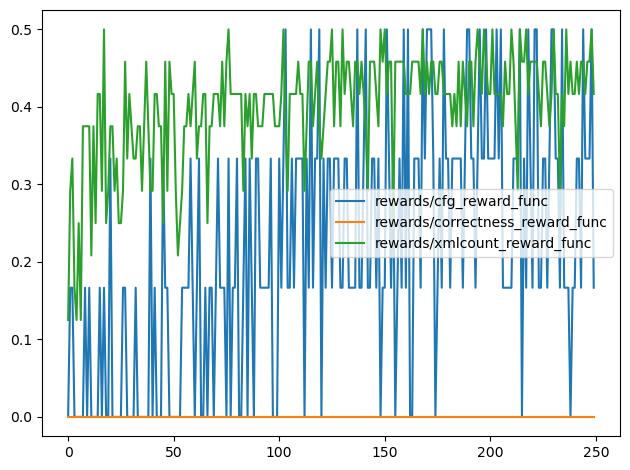

In [47]:
df_history.plot(
    y=['rewards/cfg_reward_func', 'rewards/correctness_reward_func', 'rewards/xmlcount_reward_func'], 
    use_index=True
)
plt.tight_layout()

### Selecting best of N answers

## Neural transduction

## Neurosymbolic search

The model makes a proposal for SCM or MHMC